## Three-way classifier: home, rehab, expired

Now, we'll see how well we can differentiate not just between patients who live or die, but also patients who are well enough to get discharged home.

In [34]:
# Import libraries
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import requests
import sklearn

from collections import Counter

# Import sklearn functions
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

%matplotlib inline

In [3]:
%%bash
ls pkls/

X_train_test_y_train_test.pkl
X_y_ternary.pkl
cardiac_arrest_dfs.pkl
dem_hosp_dx_proc_orig_X_dfs.pkl
full_X_y_df.pkl
logr_tree_forest_gridsearch.pkl
logr_tree_forest_svc_gridsearch.pkl
master_influenza_df.pkl
scaled_X_train_test_y_train_test.pkl
svm_logr_tree_forest_mlp_gridsearch.pkl
y_h2o_test_df.pkl


In [19]:
with open("pkls/X_y_ternary.pkl", "rb") as picklefile:
    [X_ternary, y_ternary] = pickle.load(picklefile)

In [20]:
with open("pkls/scaled_X_train_test_y_train_test.pkl", "rb") as picklefile:
    [X_train, X_test, y_train, y_test] = pickle.load(picklefile)

In [21]:
y_ternary.value_counts()

expired    8733
rehab      2303
home       1668
Name: pat_status, dtype: int64

In [26]:
y_train = []
for i in X_train.index:
    y_train.append(y_ternary[i])
    
y_train = pd.Series(y_train, index=X_train.index)

In [27]:
y_test = []
for i in X_test.index:
    y_test.append(y_ternary[i])
    
y_test = pd.Series(y_test, index=X_test.index)

In [30]:
1668/12704

0.13129722921914358

In [ ]:
models = [('svm', SVC),
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier),
          ('gradient boosted tree', GradientBoostingClassifier),
          ('mlpc', MLPClassifier)
         ]

param_choices = [
    {
        'C': [0.1, 1.0, 10],
        'gamma': [0.01, 0.1, 1] ,
        'probability': [True]
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [2, 4, 6, 8],
        'min_samples_leaf': [5, 10, 15]
    },
    {
        'hidden_layer_sizes': [50, 100, 150],
        'alpha': [0.00001, 0.0001, 0.001],
        'max_iter': [1000]
    }
]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    print("Doing grid search for {}.".format(name))
    grid = GridSearchCV(model(), params)
    grid.fit(X_train, y_train)
    s = f"{name}: best score: {grid.best_score_}"
    print(s)
    grids[name] = grid

In [40]:
svm = SVC()
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [41]:
svm.score(X_train, y_train)

0.7697530256813933

In [46]:
plain_models = {}

plain_models['svm'] = SVC()
plain_models['logistic'] = LogisticRegression()
plain_models['tree'] = DecisionTreeClassifier()
plain_models['forest'] = RandomForestClassifier()
plain_models['gb_tree'] = GradientBoostingClassifier()
plain_models['mlpc'] = MLPClassifier(max_iter=1000)

In [48]:
conf_matrices = {}

for key, model in plain_models.items():
    model.fit(X_train, y_train)
    score = model.score(X_train, y_train)
    print("Accuracy score for {}: ".format(key) + str(score))
    y_test_pred = model.predict(X_test)
    conf_matrices[key] = confusion_matrix(y_test, y_test_pred)

Accuracy score for svm: 0.7697530256813933
Accuracy score for logistic: 0.7689658565384236
Accuracy score for tree: 0.9999016038571288
Accuracy score for forest: 0.9872085014267441
Accuracy score for gb_tree: 0.8171799665453114
Accuracy score for mlpc: 0.9997048115713864


In [68]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

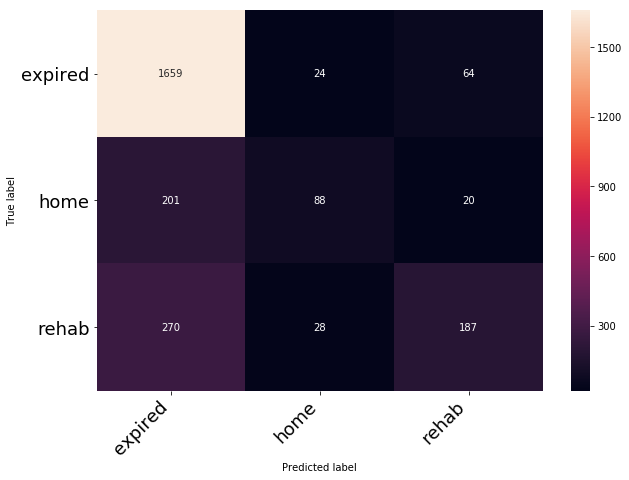

In [69]:
fig = print_confusion_matrix(conf_matrices['svm'], class_names=['expired', 'home', 'rehab'])

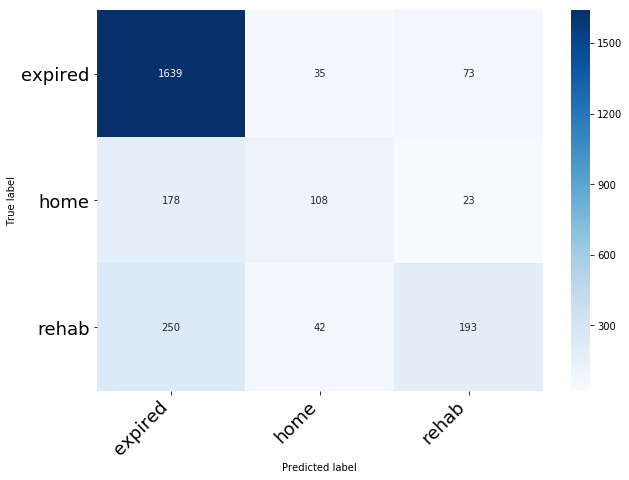

In [63]:
fig = print_confusion_matrix(conf_matrices['logistic'], class_names=['expired', 'home', 'rehab'])

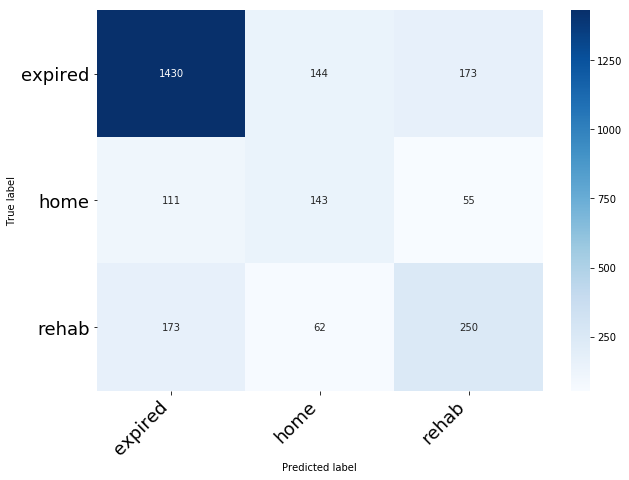

In [64]:
fig = print_confusion_matrix(conf_matrices['tree'], class_names=['expired', 'home', 'rehab'])

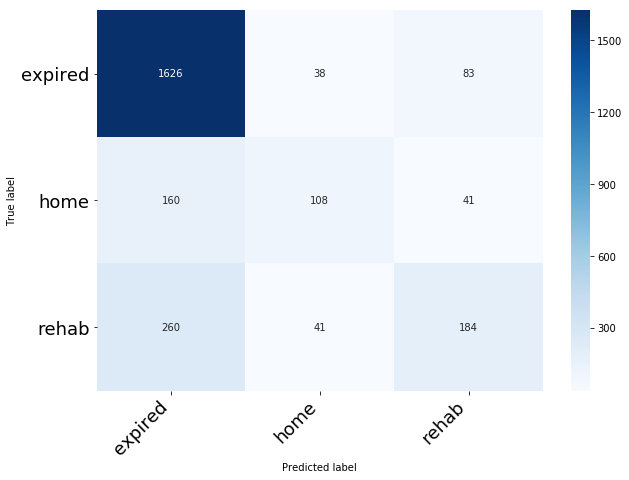

In [65]:
fig = print_confusion_matrix(conf_matrices['forest'], class_names=['expired', 'home', 'rehab'])

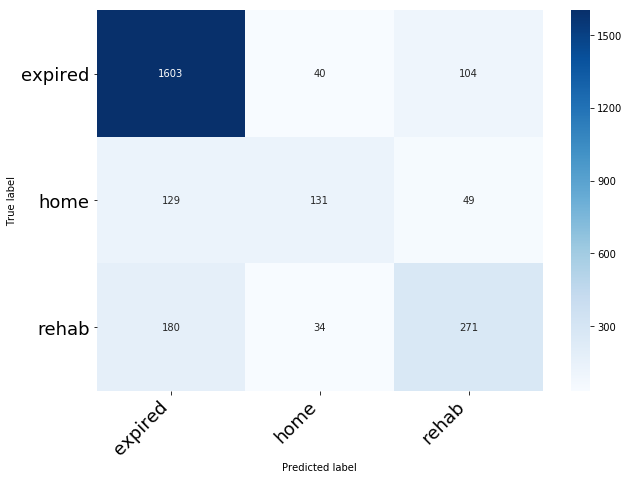

In [66]:
fig = print_confusion_matrix(conf_matrices['gb_tree'], class_names=['expired', 'home', 'rehab'])

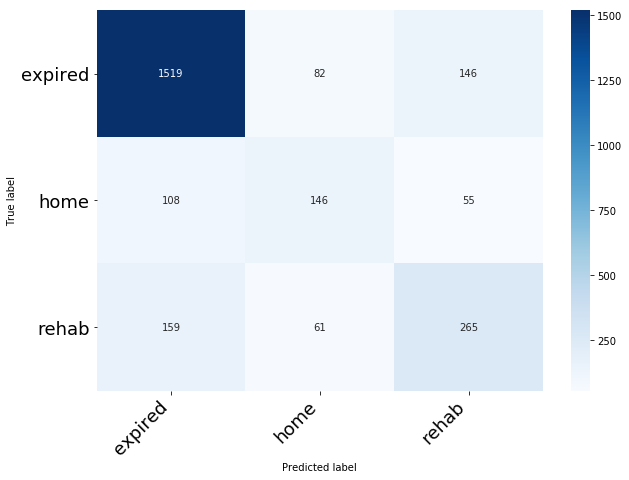

In [67]:
fig = print_confusion_matrix(conf_matrices['mlpc'], class_names=['expired', 'home', 'rehab'])

In [60]:
for name, model in plain_models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    acc_score = accuracy_score(y_train, y_train_pred)
    print("The accuracy for {} on the training set is {}".format(name, str(acc_score)))
    print(classification_report(y_train, y_train_pred))
    
    y_test_pred = model.predict(X_test)
    acc_score = accuracy_score(y_test, y_test_pred)
    print("The accuracy for {} on the test set is {}".format(name, str(acc_score)))
    print(classification_report(y_test, y_test_pred))
    print("_____________\n")

The accuracy for svm on the training set is 0.7697530256813933
             precision    recall  f1-score   support

    expired       0.78      0.96      0.86      6986
       home       0.72      0.32      0.44      1359
      rehab       0.69      0.39      0.50      1818

avg / total       0.76      0.77      0.74     10163

The accuracy for svm on the test set is 0.7611176702085793
             precision    recall  f1-score   support

    expired       0.78      0.95      0.86      1747
       home       0.63      0.28      0.39       309
      rehab       0.69      0.39      0.49       485

avg / total       0.74      0.76      0.73      2541

_____________

The accuracy for logistic on the training set is 0.7689658565384236
             precision    recall  f1-score   support

    expired       0.79      0.95      0.86      6986
       home       0.67      0.36      0.47      1359
      rehab       0.66      0.39      0.49      1818

avg / total       0.75      0.77      0.74   

In [71]:
list(X_train.columns)

['sex_code_F',
 'sex_code_M',
 'sex_code_U',
 'race_1',
 'race_2',
 'race_3',
 'race_4',
 'race_5',
 'race_`',
 'ethnicity_1',
 'ethnicity_2',
 'ethnicity_`',
 'public_health_region_01',
 'public_health_region_02',
 'public_health_region_03',
 'public_health_region_04',
 'public_health_region_05',
 'public_health_region_06',
 'public_health_region_07',
 'public_health_region_08',
 'public_health_region_09',
 'public_health_region_10',
 'public_health_region_11',
 'first_payment_src_09',
 'first_payment_src_11',
 'first_payment_src_12',
 'first_payment_src_13',
 'first_payment_src_14',
 'first_payment_src_15',
 'first_payment_src_16',
 'first_payment_src_AM',
 'first_payment_src_BL',
 'first_payment_src_CH',
 'first_payment_src_CI',
 'first_payment_src_HM',
 'first_payment_src_LM',
 'first_payment_src_MA',
 'first_payment_src_MB',
 'first_payment_src_MC',
 'first_payment_src_OF',
 'first_payment_src_VA',
 'first_payment_src_WC',
 'first_payment_src_ZZ',
 'pat_age',
 'hiv_drug',
 'type_o